In [120]:
from collections import defaultdict
from pathlib import Path

import networkx
import numpy

import pandas
import snkit

from pyproj import Geod
from scipy.integrate import simpson
from tqdm.auto import tqdm

In [3]:
# set up variables for incoming and processed data paths
project_path = Path().resolve().parent # assume we're running from the project scripts directory, so get the parent
incoming_data_path = project_path / "incoming_data"
processed_data_path = project_path / "processed_data"

In [5]:
power_network_path = processed_data_path / "networks" / "power" / "power_network.2025-05-01.gpkg"
network = snkit.network.read_file(power_network_path, nodes_layer="power_nodes", edges_layer="power_edges")

In [83]:
geod = Geod(ellps="WGS84")
network.edges["length_m"] = network.edges.geometry.apply(geod.geometry_length)

In [99]:
G = networkx.Graph()
G.add_nodes_from(
    (
        n.id,
        {"id": n.id, "asset_type": n.asset_type, "population": n.population, "capacity_mw": n.capacity_mw}
    )
    for n in network.nodes.itertuples()
)
G.add_edges_from(
    (
        e.from_id,
        e.to_id,
        {"id": e.id, "length_m": e.length_m}
    )
    for e in network.edges.itertuples()
)

In [33]:
components = list(networkx.connected_components(G))
node_dfs = []
for component_id, component in enumerate(tqdm(components)):
    c = G.subgraph(component).copy()
    c_nodes = pandas.DataFrame(n for _, n in c.nodes(data=True))

    # component total pop and capacity
    c_pop = c_nodes.population.sum()
    c_cap = c_nodes.capacity_mw.sum()
    c_nodes["nominal_mw_per_connected_person"] = (c_nodes.population > 0) * c_cap / c_pop
    c_nodes["component_id"] = component_id
    node_dfs.append(c_nodes)
nominal_nodes = pandas.concat(node_dfs)
nominal_nodes.query("asset_type == 'demand'")

  0%|          | 0/873 [00:00<?, ?it/s]

,id,asset_type,population,capacity_mw,nominal_mw_per_connected_person,component_id
184,node_218,demand,62.929560,0.0,0.000417,0
185,node_224,demand,135.172406,0.0,0.000417,0
186,node_227,demand,23.478839,0.0,0.000417,0
187,node_228,demand,1145.691480,0.0,0.000417,0
188,node_230,demand,0.000000,0.0,0.000000,0
...,...,...,...,...,...,...
28,node_19489,demand,970.366344,0.0,0.000000,865
31,node_19488,demand,1688.196098,0.0,0.000000,865
0,node_19496,demand,1040.521959,0.0,0.000000,866
1,node_19498,demand,8.487362,0.0,0.000000,867


In [36]:
nominal_nodes = network.nodes.set_index("id").join(nominal_nodes[["id", "nominal_mw_per_connected_person", "component_id"]].set_index("id"))

<Axes: >

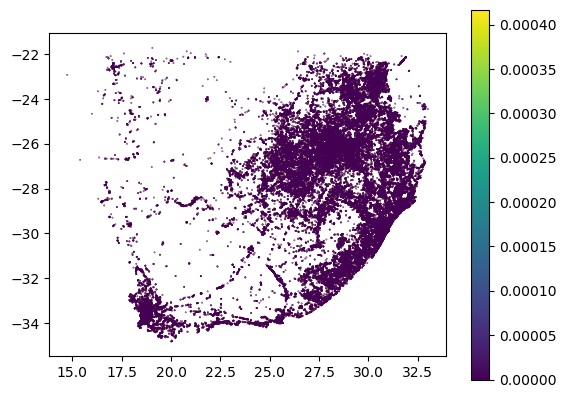

In [88]:
nominal_nodes.plot(column="nominal_mw_per_connected_person", legend=True, marker="o", markersize=0.1)

In [54]:
(project_path / "results").mkdir(exist_ok=True)
nominal_nodes[["nominal_mw_per_connected_person", "asset_type"]] \
    .fillna({"nominal_mw_per_connected_person": 0}) \
    .to_csv(project_path / "results" / "nodes_with_nominal_mw_per_person.csv")

## Calculate disruption

In [123]:
disrupted_generation = pandas.read_csv(project_path/ "results" / "generation_nodes_with_damages.csv")
disrupted_node_ids = list(disrupted_generation.id)
disrupted_node_ids

['node_1', 'node_5', 'node_174', 'node_197']

In [124]:
disrupted_nodes = network.nodes.set_index("id")

def calculate_mw_per_person(G, colname="mw_per_connected_person"):
    components = list(networkx.connected_components(G))
    node_dfs = []
    for component_id, component in enumerate(components):
        c = G.subgraph(component)
        c_nodes = pandas.DataFrame(n for _, n in c.nodes(data=True))

        # component total pop and capacity
        c_pop = c_nodes.population.sum()
        c_cap = c_nodes.capacity_mw.sum()
        c_nodes[colname] = (c_nodes.population > 0) * c_cap / c_pop
        node_dfs.append(c_nodes)
    return pandas.concat(node_dfs)

for node_id in tqdm(disrupted_node_ids):
    nominal_cap = G.nodes[node_id]['capacity_mw']
    G.nodes[node_id]['capacity_mw'] = 0

    disrupted_cap = calculate_mw_per_person(G, colname=node_id)
    disrupted_nodes = disrupted_nodes.join(disrupted_cap[["id", node_id]].set_index("id"))

    G.nodes[node_id]['capacity_mw'] = nominal_cap
disrupted_nodes.query("asset_type == 'demand'")

  0%|          | 0/4 [00:00<?, ?it/s]

,generation_type,name,capacity_mw,asset_type,population,geometry,node_1,node_5,node_174,node_197
id,,,,,,,,,,
node_217,,,0.0,demand,0.000000,POINT (17.25833 -22.12083),NaN,NaN,NaN,NaN
node_218,,,0.0,demand,62.929560,POINT (26.925 -22.12083),0.000408,0.000411,0.000416,0.000417
node_219,,,0.0,demand,650.472893,POINT (22.41667 -22.1224),0.000000,0.000000,0.000000,0.000000
node_220,,,0.0,demand,130.910554,POINT (29.62667 -22.12833),0.000000,0.000000,0.000000,0.000000
node_221,,,0.0,demand,0.862991,POINT (22.42083 -22.13542),0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
node_19497,,,0.0,demand,164.832179,POINT (20.21759 -34.65463),0.000408,0.000411,0.000416,0.000417
node_19498,,,0.0,demand,8.487362,POINT (19.51875 -34.6625),0.000000,0.000000,0.000000,0.000000
node_19499,,,0.0,demand,2820.542945,POINT (20.03398 -34.78494),0.000000,0.000000,0.000000,0.000000


In [125]:
disruption_comparison = disrupted_nodes \
    .query("asset_type == 'demand'") \
    .join(nominal_nodes[["nominal_mw_per_connected_person"]]) \
    .query("nominal_mw_per_connected_person > 0")
disruption_comparison

,generation_type,name,capacity_mw,asset_type,population,geometry,node_1,node_5,node_174,node_197,nominal_mw_per_connected_person
id,,,,,,,,,,,
node_218,,,0.0,demand,62.929560,POINT (26.925 -22.12083),0.000408,0.000411,0.000416,0.000417,0.000417
node_224,,,0.0,demand,135.172406,POINT (20.86111 -22.14028),0.000408,0.000411,0.000416,0.000417,0.000417
node_227,,,0.0,demand,23.478839,POINT (29.69584 -22.15417),0.000408,0.000411,0.000416,0.000417,0.000417
node_228,,,0.0,demand,1145.691480,POINT (20.86583 -22.15667),0.000408,0.000411,0.000416,0.000417,0.000417
node_234,,,0.0,demand,224.145810,POINT (29.57847 -22.16389),0.000408,0.000411,0.000416,0.000417,0.000417
...,...,...,...,...,...,...,...,...,...,...,...
node_19491,,,0.0,demand,292.916047,POINT (19.35625 -34.6125),0.000408,0.000411,0.000416,0.000417,0.000417
node_19492,,,0.0,demand,102.416992,POINT (19.37708 -34.6125),0.000408,0.000411,0.000416,0.000417,0.000417
node_19497,,,0.0,demand,164.832179,POINT (20.21759 -34.65463),0.000408,0.000411,0.000416,0.000417,0.000417


In [126]:
node_disruption = []
for node_id in disrupted_node_ids:
    disruption_comparison[f"{node_id}_fraction"] = disruption_comparison[node_id] / disruption_comparison.nominal_mw_per_connected_person
    population_with_capacity_drop = disruption_comparison.query(f"{node_id}_fraction < 0.99").population.sum()
    node_disruption.append({
        "node_id": node_id,
        "population_with_capacity_factor_below_threshold": population_with_capacity_drop
    })
node_disruption = pandas.DataFrame(node_disruption)
node_disruption.to_csv(project_path / "results" / "generation_node_disruption.csv")

In [127]:
join_disruption = disrupted_generation.set_index("id")

In [128]:
for colname in join_disruption.columns:
    if "damage_cost" in colname:
        disruption_colname = colname.replace("damage_cost", "population_disrupted")
        join_disruption = join_disruption.join(node_disruption.set_index("node_id")).rename(columns={
            "population_with_capacity_factor_below_threshold": disruption_colname
        })
        join_disruption[disruption_colname] = join_disruption[disruption_colname] * (join_disruption[colname] > 0)
join_disruption

,generation_type,name,capacity_mw,asset_type,population,geometry,jrc_flood_rp500_damage_cost,jrc_flood_rp200_damage_cost,jrc_flood_rp100_damage_cost,jrc_flood_rp50_damage_cost,jrc_flood_rp20_damage_cost,jrc_flood_rp10_damage_cost,jrc_flood_ead,jrc_flood_rp500_population_disrupted,jrc_flood_rp200_population_disrupted,jrc_flood_rp100_population_disrupted,jrc_flood_rp50_population_disrupted,jrc_flood_rp20_population_disrupted,jrc_flood_rp10_population_disrupted
id,,,,,,,,,,,,,,,,,,,
node_1,hydropower,Gariep hydroelectric plant,360.0,generation,0.0,POINT (25.5067 -30.6233),3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,2.940000e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07
node_5,hydropower,Vanderkloof hydroelectric plant,240.0,generation,0.0,POINT (24.7317 -29.9911),3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,2.940000e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07
node_174,solar,Lekwa-Teemane Local Municipality Dr Ruth Segom...,1.2,generation,0.0,POINT (25.6047 -27.6638),6.440000e+06,1.920000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.378489e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
node_197,solar,Sol Plaatje Local Municipality Frances Baard D...,1.1,generation,0.0,POINT (24.4768 -28.9918),3.296000e+07,3.008000e+07,2.748000e+07,2.492000e+07,2.140000e+07,1.816000e+07,2.153008e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [131]:
rp_cols = [c for c in join_disruption.columns if "population_disrupted" in c]
def get_rp(col):
    return int(col.replace("jrc_flood_rp", "").replace("_population_disrupted", ""))

rp_cols = sorted(rp_cols, key=lambda col: 1 / get_rp(col))
rps = numpy.array([get_rp(col) for col in rp_cols])
probabilities = 1 / rps
rp_damages = join_disruption[rp_cols]
ead = simpson(rp_damages, x=probabilities, axis=1)
join_disruption["jrc_flood_eapa"] = ead


join_disruption.to_csv(project_path / "results" / "generation_nodes_with_damages_and_disruption.csv")
join_disruption

,generation_type,name,capacity_mw,asset_type,population,geometry,jrc_flood_rp500_damage_cost,jrc_flood_rp200_damage_cost,jrc_flood_rp100_damage_cost,jrc_flood_rp50_damage_cost,jrc_flood_rp20_damage_cost,jrc_flood_rp10_damage_cost,jrc_flood_ead,jrc_flood_rp500_population_disrupted,jrc_flood_rp200_population_disrupted,jrc_flood_rp100_population_disrupted,jrc_flood_rp50_population_disrupted,jrc_flood_rp20_population_disrupted,jrc_flood_rp10_population_disrupted,jrc_flood_eapa
id,,,,,,,,,,,,,,,,,,,,
node_1,hydropower,Gariep hydroelectric plant,360.0,generation,0.0,POINT (25.5067 -30.6233),3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,2.940000e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.391996e+06
node_5,hydropower,Vanderkloof hydroelectric plant,240.0,generation,0.0,POINT (24.7317 -29.9911),3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,3.000000e+08,2.940000e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.481628e+07,4.391996e+06
node_174,solar,Lekwa-Teemane Local Municipality Dr Ruth Segom...,1.2,generation,0.0,POINT (25.6047 -27.6638),6.440000e+06,1.920000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.378489e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
node_197,solar,Sol Plaatje Local Municipality Frances Baard D...,1.1,generation,0.0,POINT (24.4768 -28.9918),3.296000e+07,3.008000e+07,2.748000e+07,2.492000e+07,2.140000e+07,1.816000e+07,2.153008e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Check components

In [49]:
nominal_nodes.component_id.value_counts()#.plot.hist(bins=100)

component_id
0      78538
649      146
844      100
238       39
127       34
       ...  
304        1
305        1
306        1
307        1
294        1
Name: count, Length: 873, dtype: int64

<Axes: >

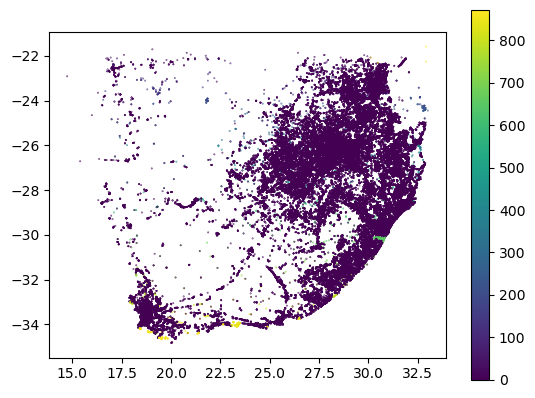

In [39]:
nominal_nodes.plot(column="component_id", legend=True, marker="o", markersize=0.1)

## Assignment of "nominal flows" from generation to demand

Non-physical model routes each population to connected generators in proportion to their capacity, along the shortest path on the network.

In [85]:
def edge_link_ids_from_nodes(route_nodes):
    next_nodes = iter(route_nodes)
    next(next_nodes)
    return [
        "__".join(sorted([u, v]))
        for u, v in zip(route_nodes, next_nodes)
    ]

def assign_component_pop(G, component):
    # create connected component subgraph
    c = G.subgraph(component).copy()
    # nodes dataframe
    c_nodes = pandas.DataFrame(n for _, n in c.nodes(data=True))

    # component total pop and capacity
    c_pop = c_nodes.population.sum()
    c_cap = c_nodes.capacity_mw.sum()

    # assign pop to nodes in proportion to capacity
    def assign_source_pop(n):
        if n.asset_type == 'generation':
            return n.capacity_mw * c_pop / c_cap
        return n.population

    c_nodes['population'] = c_nodes.apply(assign_source_pop, axis=1)

    # assign pop "flow" along shortest path from source to target, sharing source
    # pop proportionally between targets
    edge_links = defaultdict(int)
    sources = c_nodes[c_nodes.asset_type == 'generation'].copy()
    targets = c_nodes[c_nodes.asset_type == 'demand'].copy()
    if len(sources) and len(targets):
        for u in tqdm(sources.itertuples(), total=len(sources)):
            paths = networkx.shortest_path(c, source=u.id, weight="length_m")
            for v in targets.itertuples():
                path = paths[v.id]
                path_pop = u.population * (v.population / c_pop)
                for link_id in edge_link_ids_from_nodes(path):
                    edge_links[link_id] += path_pop

    c_edges = pandas.DataFrame({'link': k, 'population': v} for k, v in edge_links.items())

    return c_nodes[['id', 'population']], c_edges


def assign_node_edge_pop(G):
    components = list(networkx.connected_components(G))
    node_pops = []
    edge_pops = []

    for component in components:
        c_node_pop, c_edge_pop = assign_component_pop(G, component)
        if len(c_node_pop):
            node_pops.append(c_node_pop)
        if len(c_edge_pop):
            edge_pops.append(c_edge_pop)

    node_pop = pandas.concat(node_pops)
    edge_pop = pandas.concat(edge_pops)

    return node_pop, edge_pop


In [86]:
node_pop, edge_pop = assign_node_edge_pop(G)

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

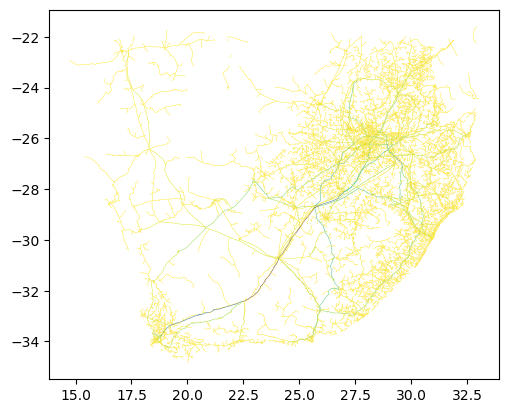

In [89]:
# set up edge ids using from/to node ids, both ways around
network.edges["link"] = network.edges.from_id + "__" + network.edges.to_id
network.edges["link_r"] = network.edges.to_id + "__" + network.edges.from_id

a = edge_pop.set_index("link").join(network.edges.set_index("link")).dropna(subset="id").reset_index(drop=True)
b = edge_pop.set_index("link").join(network.edges.set_index("link_r")).dropna(subset="id").reset_index(drop=True)
edge_id_pop = pandas.concat([a[["id", "population"]], b[["id", "population"]]]).drop_duplicates(subset="id").set_index("id")

network.edges.drop(columns=["link", "link_r"], inplace=True)
edges_with_flow = network.edges.set_index("id").join(edge_id_pop).fillna({"population":0})
edges_with_flow.plot(column="population", cmap="viridis_r", linewidth=0.3)